# 0. Install Dependencies and Bring in Data

In [43]:
#tensorflow to create the sequential mode
#pandas to read the data
#matplotlib to plot the data
#sklearn to split the data
!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'error'


  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [44 lines of output]
      Traceback (most recent call last):
        File "c:\Users\CYTech Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\setuptools\_vendor\packaging\requirements.py", line 35, in __init__
          parsed = _parse_requirement(requirement_string)
                   ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\CYTech Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 64, in parse_requirement
          return _parse_requirement(Tokenizer(source, rules=DEFAULT_RULES))
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
        File "c:\Users\CYTech Student\AppData\Local\Programs\Python\Python312\Lib\site-packages\setuptools\_vendor\packaging\_parser.py", line 82, in _parse_requirement
          url, specifier, marker = _parse_requirem

In [44]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np

In [80]:
df = pd.read_csv(os.path.join('jigsaw-toxic-comment-classification-challenge','train.csv', 'train.csv'))

#limit the data to 5000 rows
df = df.head(5000)
df.shape

(5000, 8)

# 1. Preprocess

In [46]:
!pip list

Package                     Version
--------------------------- ----------------
absl-py                     2.1.0
aiofiles                    24.1.0
aiohttp                     3.9.5
aiosignal                   1.3.1
albucore                    0.0.17
albumentations              1.4.18
annotated-types             0.7.0
anyio                       4.4.0
argcomplete                 3.5.1
argon2-cffi                 23.1.0
argon2-cffi-bindings        21.2.0
arrow                       1.3.0
asttokens                   2.4.1
astunparse                  1.6.3
async-lru                   2.0.4
attrs                       23.2.0
babel                       2.16.0
beautifulsoup4              4.12.3
bleach                      6.1.0
blis                        1.0.1
boto3                       1.35.58
botocore                    1.35.58
Brotli                      1.1.0
cachetools                  5.5.0
catalogue                   2.0.10
certifi                     2024.2.2
cffi               

In [81]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [82]:
#all the comments
x = df['comment_text']
print(x)


0       Explanation\nWhy the edits made under my usern...
1       D'aww! He matches this background colour I'm s...
2       Hey man, I'm really not trying to edit war. It...
3       "\nMore\nI can't make any real suggestions on ...
4       You, sir, are my hero. Any chance you remember...
                              ...                        
4995    "\n\nHello Marcruhwedell, and Welcome to Wikip...
4996    ...that's why I did ....cheers,   (talk · cont...
4997    No, it's not a delayed reaction\n\nI just happ...
4998    "\n\nA slight difference with you\nI have to d...
4999    "\n\nNonsense.  The truth is NO schools give s...
Name: comment_text, Length: 5000, dtype: object


In [83]:
#all the labels
y = df[df.columns[2:]].values
print(len(y))


5000


In [85]:
#Number of words in the vocab
MAX_WORDS = 20000 

In [86]:
#Vectorize the text
from tensorflow.keras.layers import TextVectorization
vectorizer = TextVectorization(max_tokens=MAX_WORDS,
                               output_sequence_length=1800,
                               output_mode='int')

In [87]:
type(x.values)

numpy.ndarray

In [88]:
#Learn the vocabulary from the text
vectorizer.adapt(x.values)

In [89]:
vectorizer('This is a project')[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([ 14,   9,   6, 408], dtype=int64)>

In [90]:
#Vectorize the text
vectorized_text = vectorizer(x.values)

In [91]:
#The vectorized text of all the comments
vectorized_text

<tf.Tensor: shape=(5000, 1800), dtype=int64, numpy=
array([[ 602,   76,    2, ...,    0,    0,    0],
       [   1,   55, 1825, ...,    0,    0,    0],
       [ 504,  412,   69, ...,    0,    0,    0],
       ...,
       [  48,   46,   15, ...,    0,    0,    0],
       [   6, 5215,  878, ...,    0,    0,    0],
       [ 742,    2,  559, ...,    0,    0,    0]], dtype=int64)>

In [92]:
# Pass the limited vectorized text and the labels to the dataset
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [93]:
batch_x, batch_y= dataset.as_numpy_iterator().next()

In [94]:
len(dataset) #Number of batches


313

In [95]:
int(len(dataset)*0.7) #Number of batches for training

219

In [96]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [97]:
len(train), len(val), len(test)

(219, 62, 31)

# 2. Create Sequential Model

In [98]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [99]:
model = Sequential()
# Create the embedding layer 
model.add(Embedding(MAX_WORDS+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
# Final layer 
model.add(Dense(6, activation='sigmoid'))


In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

In [101]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 139s 621ms/step - loss: 0.2862 - val_loss: 0.1364
Epoch 2/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 144s 660ms/step - loss: 0.1238 - val_loss: 0.0658
Epoch 3/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 150s 685ms/step - loss: 0.0714 - val_loss: 0.0510
Epoch 4/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 163s 745ms/step - loss: 0.0549 - val_loss: 0.0506
Epoch 5/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 141s 646ms/step - loss: 0.0465 - val_loss: 0.0444
Epoch 6/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 139s 637ms/step - loss: 0.0471 - val_loss: 0.0305
Epoch 7/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 134s 612ms/step - loss: 0.0341 - val_loss: 0.0373
Epoch 8/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 128s 583ms/step - loss: 0.0311 - val_loss: 0.0300
Epoch 9/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 131s 596ms/step - loss: 0.0287 - val_loss: 0.0304
Epoch 10/10
219/219 ━━━━━━━━━━━━━━━━━━━━ 129s 589ms/step - loss: 0.0267 - val_loss: 0.0249


In [102]:
from matplotlib import pyplot as plt

<Figure size 800x500 with 0 Axes>

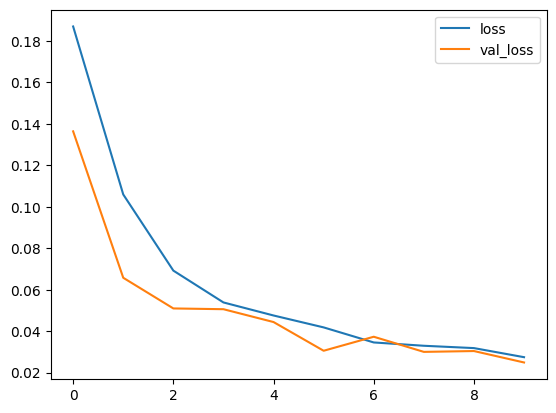

In [103]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

# 3. Make Predictions

In [140]:
input_text1= vectorizer('I hate you. You are disgusting.')
input_text2= vectorizer('I love you. You are amazing.')
input_text3= vectorizer('Go kill yourself :)')
input_text4= vectorizer('You are the worst human being on earth. Fuck you!!!')
input_text5= vectorizer('You are a fucking retard you bitch')

In [115]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [141]:
model.predict(np.expand_dims(input_text3, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


array([[0.97578096, 0.01032975, 0.54195213, 0.01336116, 0.45329836,
        0.01793932]], dtype=float32)

In [143]:
batch= test.as_numpy_iterator().next()

In [150]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [151]:
(model.predict(batch_x) > 0.5).astype(int)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 1, 0, 1, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [152]:
res=model.predict(np.expand_dims(input_text,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


# 4. Evaluate Model

In [153]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [154]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [157]:
for batch in test.as_numpy_iterator(): 
    # Unpack the batch 
    x_true, y_true = batch
    # Make a prediction 
    yhat = model.predict(X_true)
    
    # Flatten the predictions
    y_true = y_true.flatten()
    yhat = yhat.flatten()
    
    pre.update_state(y_true, yhat)
    re.update_state(y_true, yhat)
    acc.update_state(y_true, yhat)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/st

In [158]:
print(f'Precision: {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision: 0.8999999761581421, Recall:0.26644736528396606, Accuracy:0.1666666716337204


# 5. Test and Gradio

In [159]:
!pip install gradio jinja2

   ---------------------------------------- 0.0/57.5 MB ? eta -:--:--
   -- ------------------------------------- 2.9/57.5 MB 13.9 MB/s eta 0:00:04
   ------ --------------------------------- 9.2/57.5 MB 22.0 MB/s eta 0:00:03
   ------------ --------------------------- 17.6/57.5 MB 28.4 MB/s eta 0:00:02
   ----------------- ---------------------- 25.7/57.5 MB 31.9 MB/s eta 0:00:01
   ------------------------ --------------- 35.7/57.5 MB 34.8 MB/s eta 0:00:01
   -------------------------------- ------- 46.4/57.5 MB 37.4 MB/s eta 0:00:01
   -------------------------------------- - 56.1/57.5 MB 38.8 MB/s eta 0:00:01
   ---------------------------------------- 57.5/57.5 MB 36.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/9.7 MB ? eta -:--:--
   ---------------------------------------  9.4/9.7 MB 45.2 MB/s eta 0:00:01
   ---------------------------------------- 9.7/9.7 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: aiofiles
    Found existing installation: aiofiles 24

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yolov5 7.0.14 requires huggingface-hub<0.25.0,>=0.12.0, but you have huggingface-hub 0.27.1 which is incompatible.


In [160]:
import tensorflow as tf
import gradio as gr

In [161]:
model.save('toxicity.h5')

In [162]:
model = tf.keras.models.load_model('toxicity.h5')

In [163]:
input_str = vectorizer('hey i freaken hate you!')

In [164]:
res = model.predict(np.expand_dims(input_str,0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step


In [165]:
res

array([[0.9551404 , 0.00355768, 0.26390958, 0.01064805, 0.27149954,
        0.00833667]], dtype=float32)

In [166]:
def score_comment(comment):
    vectorized_comment = vectorizer([comment])
    results = model.predict(vectorized_comment)
    
    text = ''
    for idx, col in enumerate(df.columns[2:]):
        text += '{}: {}\n'.format(col, results[0][idx]>0.5)
    
    return text

In [170]:
interface = gr.Interface(fn=score_comment, 
                         inputs=gr.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

In [171]:
interface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860

Could not create share link. Please check your internet connection or our status page: https://status.gradio.app.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
